In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "M_264_5k_fully"
    npy_file_name_aniso = f"p_ori_fully5d_fz_aveE_f1.0_t0.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_ori_fully5d_fz_aveE_f1.0_t0.0_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The M_264_5k_fully data size is: (51, 264, 264, 264)
READING DATA DONE
The M_264_5k_fully energy data size is: (51, 264, 264, 264)
READING ENERGY DATA DONE


In [3]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 5000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 64
                loop_times = 5
                R = np.zeros((size_x,size_y,size_z,4))
                smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                smoothing_class.linear3d_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j,k]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j,k]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

100%|██████████| 51/51 [00:00<00:00, 95.23it/s]


In [4]:
    # GB Energy information
    step_num=51
    grain_nums = 5000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:00<00:00, 145.52it/s]


In [5]:
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            if abs(GB_infomation_dict_list[time_step-2][key][4]) < curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 4058/4058 [00:18<00:00, 221.75it/s]


finish 0 with num of GBs 183, and collected num of GBs 95


100%|██████████| 2225/2225 [01:53<00:00, 19.56it/s]


finish 1 with num of GBs 1123, and collected num of GBs 410


100%|██████████| 2730/2730 [02:37<00:00, 17.33it/s]


finish 2 with num of GBs 1557, and collected num of GBs 773


100%|██████████| 3559/3559 [03:14<00:00, 18.32it/s]


finish 4 with num of GBs 1989, and collected num of GBs 1554


 77%|███████▋  | 2883/3756 [02:41<00:37, 23.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 3212/3212 [02:43<00:00, 19.69it/s]


finish 11 with num of GBs 1675, and collected num of GBs 3250


100%|██████████| 3060/3060 [02:30<00:00, 20.34it/s]


finish 12 with num of GBs 1554, and collected num of GBs 3359


100%|██████████| 2919/2919 [03:00<00:00, 16.18it/s]


finish 13 with num of GBs 1419, and collected num of GBs 3470


100%|██████████| 2775/2775 [02:25<00:00, 19.12it/s]


finish 14 with num of GBs 1363, and collected num of GBs 3582


100%|██████████| 2623/2623 [01:58<00:00, 22.06it/s]


finish 15 with num of GBs 1294, and collected num of GBs 3686


100%|██████████| 2500/2500 [01:56<00:00, 21.38it/s]


finish 16 with num of GBs 1248, and collected num of GBs 3777


100%|██████████| 2413/2413 [01:50<00:00, 21.87it/s]


finish 17 with num of GBs 1168, and collected num of GBs 3853


100%|██████████| 2271/2271 [01:41<00:00, 22.44it/s]


finish 18 with num of GBs 1053, and collected num of GBs 3895


100%|██████████| 2160/2160 [02:04<00:00, 17.42it/s]


finish 19 with num of GBs 990, and collected num of GBs 3959


100%|██████████| 2049/2049 [02:05<00:00, 16.27it/s]


finish 20 with num of GBs 981, and collected num of GBs 4018


100%|██████████| 1972/1972 [01:25<00:00, 22.96it/s]


finish 21 with num of GBs 879, and collected num of GBs 4058


100%|██████████| 1869/1869 [01:20<00:00, 23.22it/s]


finish 22 with num of GBs 834, and collected num of GBs 4110


100%|██████████| 1786/1786 [01:19<00:00, 22.54it/s]


finish 23 with num of GBs 803, and collected num of GBs 4161


100%|██████████| 1686/1686 [01:09<00:00, 24.31it/s]


finish 24 with num of GBs 730, and collected num of GBs 4187


100%|██████████| 1618/1618 [01:05<00:00, 24.88it/s]


finish 25 with num of GBs 697, and collected num of GBs 4220


100%|██████████| 1533/1533 [01:03<00:00, 24.26it/s]


finish 26 with num of GBs 679, and collected num of GBs 4251


100%|██████████| 1464/1464 [01:02<00:00, 23.57it/s]


finish 27 with num of GBs 669, and collected num of GBs 4281


100%|██████████| 1422/1422 [00:59<00:00, 23.93it/s]


finish 28 with num of GBs 637, and collected num of GBs 4307


100%|██████████| 1357/1357 [00:54<00:00, 24.81it/s]


finish 29 with num of GBs 593, and collected num of GBs 4336


100%|██████████| 1293/1293 [00:53<00:00, 24.17it/s]


finish 30 with num of GBs 578, and collected num of GBs 4360


100%|██████████| 1241/1241 [00:49<00:00, 25.03it/s]


finish 31 with num of GBs 537, and collected num of GBs 4389


100%|██████████| 1204/1204 [00:48<00:00, 25.00it/s]


finish 32 with num of GBs 520, and collected num of GBs 4410


100%|██████████| 1159/1159 [00:44<00:00, 26.22it/s]


finish 33 with num of GBs 478, and collected num of GBs 4424


100%|██████████| 1102/1102 [00:42<00:00, 26.02it/s]


finish 34 with num of GBs 457, and collected num of GBs 4437


100%|██████████| 1057/1057 [00:40<00:00, 26.42it/s]


finish 35 with num of GBs 432, and collected num of GBs 4453


100%|██████████| 1013/1013 [00:41<00:00, 24.40it/s]


finish 36 with num of GBs 448, and collected num of GBs 4468


100%|██████████| 979/979 [00:38<00:00, 25.67it/s]


finish 37 with num of GBs 413, and collected num of GBs 4479


100%|██████████| 956/956 [00:36<00:00, 26.33it/s]


finish 38 with num of GBs 399, and collected num of GBs 4487


100%|██████████| 937/937 [00:36<00:00, 25.75it/s]


finish 39 with num of GBs 394, and collected num of GBs 4501


100%|██████████| 902/902 [00:33<00:00, 26.69it/s]


finish 40 with num of GBs 365, and collected num of GBs 4515


100%|██████████| 869/869 [00:31<00:00, 27.22it/s]


finish 41 with num of GBs 346, and collected num of GBs 4530


100%|██████████| 830/830 [00:30<00:00, 26.95it/s]


finish 42 with num of GBs 330, and collected num of GBs 4539


100%|██████████| 798/798 [00:31<00:00, 25.61it/s]


finish 43 with num of GBs 335, and collected num of GBs 4547


100%|██████████| 767/767 [00:27<00:00, 27.48it/s]


finish 44 with num of GBs 306, and collected num of GBs 4553


100%|██████████| 743/743 [00:27<00:00, 26.73it/s]


finish 45 with num of GBs 304, and collected num of GBs 4560


100%|██████████| 723/723 [00:25<00:00, 28.01it/s]


finish 46 with num of GBs 286, and collected num of GBs 4568


100%|██████████| 696/696 [00:24<00:00, 28.63it/s]


finish 47 with num of GBs 269, and collected num of GBs 4576


100%|██████████| 675/675 [00:25<00:00, 26.81it/s]


finish 48 with num of GBs 271, and collected num of GBs 4576


100%|██████████| 655/655 [00:24<00:00, 26.29it/s]


finish 49 with num of GBs 274, and collected num of GBs 4576


100%|██████████| 696/696 [00:23<00:00, 29.58it/s]


In [6]:
len(GB_id_focus_copy)

4576

In [7]:
    time_interval = 2
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 655/655 [00:00<00:00, 809210.34it/s]


In [8]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 1254
The ratio of anti-curvature GBs during whole simulations is 9.66622986202112% in 12973 GBs
dict_values([3, 2, 2, 2, 3, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 3, 4, 2, 8, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 7, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 5, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 2, 5, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 4, 2, 2, 3, 2, 2, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 6, 3, 2, 4, 3, 3, 3, 3, 2, 4, 4, 2, 4, 2, 2, 2, 4, 3, 5, 2, 4, 3, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [9]:
len(GB_list_velocity_list)

50

<Figure size 432x288 with 0 Axes>

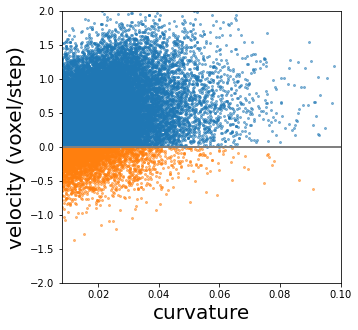

<Figure size 432x288 with 0 Axes>

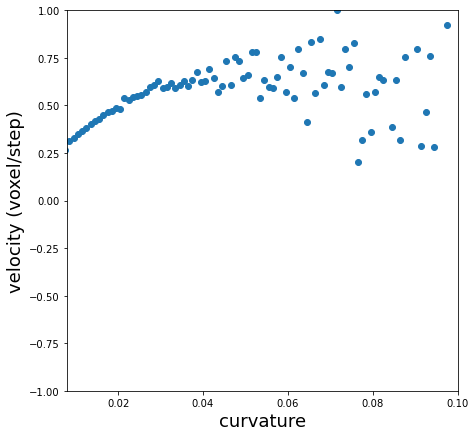

In [14]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
    velocity_1Dlist_exrandom_remove_0step = np.array(velocity_1Dlist_exrandom_remove_0step)
    curvature_1Dlist_exrandom_remove_0step = np.array(curvature_1Dlist_exrandom_remove_0step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-2.0,2.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.1])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.17560475
0.0
2.1511212872276366


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

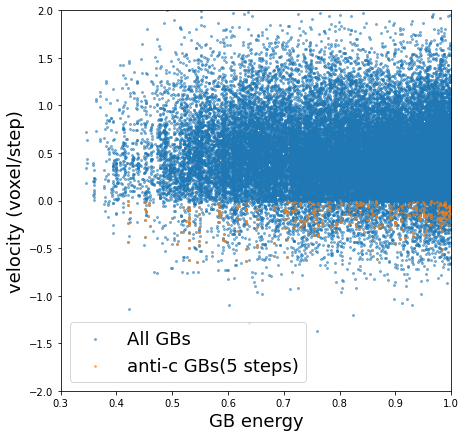

<Figure size 432x288 with 0 Axes>

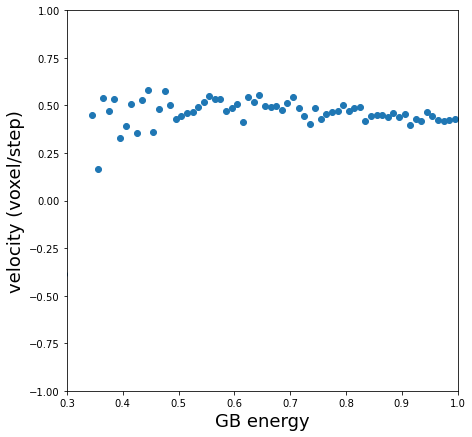

<Figure size 432x288 with 0 Axes>

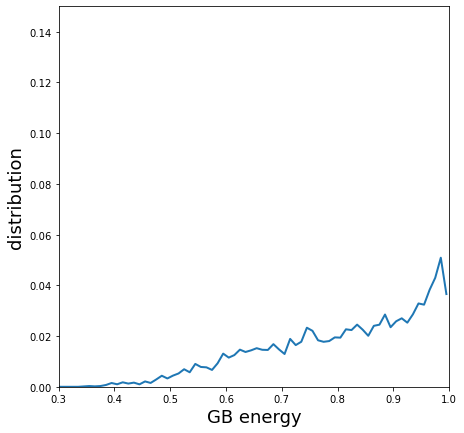

<Figure size 432x288 with 0 Axes>

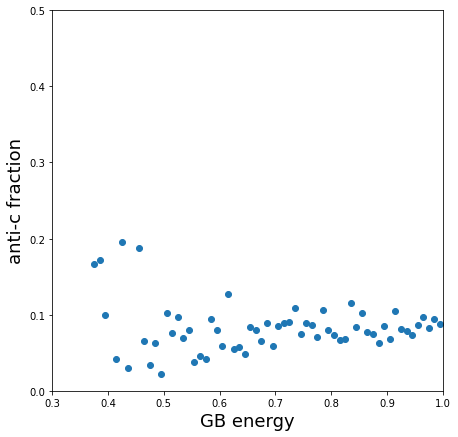

<Figure size 432x288 with 0 Axes>

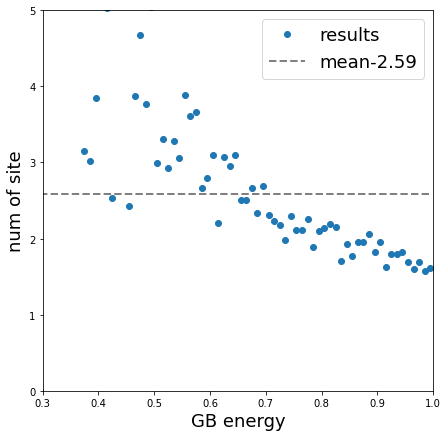

In [13]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-2,2])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/3D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        x_lim = [0.0,0.1]
        bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
        curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>x_lim[1]: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/3D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

## 2D case

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "M_20k_fully"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66_energy.npy"
    # npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso) # microstructure
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The M_20k_fully data size is: (201, 2400, 2400, 1)
READING DATA DONE
The M_20k_fully data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [3]:
    # GB information
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature with sign
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


In [4]:
    # GB Energy information
    step_num=121
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:08<00:00, 13.68it/s]


In [7]:
    time_interval = 30
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            # if abs(GB_infomation_dict_list[time_step][key][4]) < 0.0125: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            # if abs(GB_infomation_dict_list[time_step-2][key][4]) < 0.0125: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 22827/22827 [00:00<00:00, 1969501.52it/s]


finish 0 with num of GBs 0, and collected num of GBs 0


100%|██████████| 17980/17980 [00:00<00:00, 1710485.29it/s]


finish 1 with num of GBs 0, and collected num of GBs 0


100%|██████████| 15113/15113 [00:00<00:00, 89061.34it/s]


finish 2 with num of GBs 6, and collected num of GBs 4


100%|██████████| 12583/12583 [00:00<00:00, 15922.10it/s]


finish 3 with num of GBs 30, and collected num of GBs 6


100%|██████████| 10819/10819 [00:02<00:00, 4937.68it/s]


finish 4 with num of GBs 84, and collected num of GBs 20


100%|██████████| 9392/9392 [00:04<00:00, 2293.87it/s]


finish 5 with num of GBs 157, and collected num of GBs 51


100%|██████████| 8408/8408 [00:06<00:00, 1313.07it/s]


finish 6 with num of GBs 247, and collected num of GBs 104


100%|██████████| 7568/7568 [00:08<00:00, 860.93it/s] 


finish 7 with num of GBs 326, and collected num of GBs 160


100%|██████████| 6808/6808 [00:10<00:00, 644.26it/s]


finish 8 with num of GBs 393, and collected num of GBs 219


100%|██████████| 6264/6264 [00:13<00:00, 452.23it/s]


finish 9 with num of GBs 515, and collected num of GBs 303


100%|██████████| 5744/5744 [00:14<00:00, 384.27it/s]


finish 10 with num of GBs 556, and collected num of GBs 380


100%|██████████| 5350/5350 [00:17<00:00, 305.16it/s]


finish 11 with num of GBs 645, and collected num of GBs 460


100%|██████████| 5042/5042 [00:18<00:00, 269.12it/s]


finish 12 with num of GBs 705, and collected num of GBs 537


100%|██████████| 4702/4702 [00:20<00:00, 224.34it/s]


finish 13 with num of GBs 770, and collected num of GBs 624


100%|██████████| 4406/4406 [00:22<00:00, 198.43it/s]


finish 14 with num of GBs 809, and collected num of GBs 694


100%|██████████| 4142/4142 [00:23<00:00, 176.03it/s]


finish 15 with num of GBs 863, and collected num of GBs 787


100%|██████████| 3886/3886 [00:24<00:00, 156.15it/s]


finish 16 with num of GBs 913, and collected num of GBs 859


100%|██████████| 3352/3352 [00:25<00:00, 128.99it/s]


finish 19 with num of GBs 953, and collected num of GBs 1047


100%|██████████| 2905/2905 [00:27<00:00, 106.96it/s]


finish 22 with num of GBs 994, and collected num of GBs 1211


100%|██████████| 2823/2823 [00:26<00:00, 104.80it/s]


finish 23 with num of GBs 993, and collected num of GBs 1269


100%|██████████| 2737/2737 [00:27<00:00, 99.93it/s] 


finish 24 with num of GBs 1004, and collected num of GBs 1319


100%|██████████| 2639/2639 [00:26<00:00, 99.01it/s] 


finish 25 with num of GBs 978, and collected num of GBs 1366


100%|██████████| 2562/2562 [00:26<00:00, 96.55it/s] 


finish 26 with num of GBs 975, and collected num of GBs 1401


100%|██████████| 2457/2457 [00:26<00:00, 92.68it/s] 


finish 27 with num of GBs 973, and collected num of GBs 1457


100%|██████████| 2367/2367 [00:25<00:00, 91.65it/s] 


finish 28 with num of GBs 947, and collected num of GBs 1497


 98%|█████████▊| 2226/2281 [00:25<00:00, 74.18it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1116/1116 [00:19<00:00, 58.02it/s]


finish 60 with num of GBs 708, and collected num of GBs 2105


100%|██████████| 1094/1094 [00:19<00:00, 56.93it/s]


finish 61 with num of GBs 708, and collected num of GBs 2116


100%|██████████| 1067/1067 [00:19<00:00, 55.41it/s]


finish 62 with num of GBs 708, and collected num of GBs 2124


100%|██████████| 1049/1049 [00:18<00:00, 55.21it/s]


finish 63 with num of GBs 700, and collected num of GBs 2140


100%|██████████| 1039/1039 [00:18<00:00, 55.44it/s]


finish 64 with num of GBs 693, and collected num of GBs 2151


100%|██████████| 1028/1028 [00:18<00:00, 55.66it/s]


finish 65 with num of GBs 683, and collected num of GBs 2157


100%|██████████| 1010/1010 [00:18<00:00, 55.89it/s]


finish 66 with num of GBs 666, and collected num of GBs 2167


100%|██████████| 993/993 [00:18<00:00, 55.15it/s]


finish 67 with num of GBs 667, and collected num of GBs 2177


100%|██████████| 975/975 [00:17<00:00, 54.31it/s]


finish 68 with num of GBs 665, and collected num of GBs 2186


100%|██████████| 963/963 [00:17<00:00, 54.00it/s]


finish 69 with num of GBs 662, and collected num of GBs 2193


 65%|██████▌   | 624/953 [00:11<00:05, 56.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 917/917 [00:16<00:00, 54.55it/s]


finish 73 with num of GBs 621, and collected num of GBs 2214


100%|██████████| 903/903 [00:16<00:00, 54.75it/s]


finish 74 with num of GBs 608, and collected num of GBs 2217


100%|██████████| 882/882 [00:16<00:00, 54.76it/s]


finish 75 with num of GBs 596, and collected num of GBs 2220


100%|██████████| 870/870 [00:15<00:00, 54.42it/s]


finish 76 with num of GBs 592, and collected num of GBs 2229


100%|██████████| 858/858 [00:16<00:00, 53.55it/s]


finish 77 with num of GBs 587, and collected num of GBs 2237


100%|██████████| 844/844 [00:15<00:00, 54.08it/s]


finish 78 with num of GBs 574, and collected num of GBs 2243


100%|██████████| 833/833 [00:15<00:00, 54.17it/s]


finish 79 with num of GBs 570, and collected num of GBs 2248


100%|██████████| 808/808 [00:15<00:00, 51.92it/s]


finish 80 with num of GBs 576, and collected num of GBs 2251


100%|██████████| 803/803 [00:15<00:00, 52.34it/s]


finish 81 with num of GBs 568, and collected num of GBs 2261


100%|██████████| 792/792 [00:15<00:00, 52.43it/s]


finish 82 with num of GBs 558, and collected num of GBs 2264


100%|██████████| 775/775 [00:15<00:00, 51.49it/s]


finish 83 with num of GBs 556, and collected num of GBs 2267


100%|██████████| 765/765 [00:15<00:00, 50.89it/s]


finish 84 with num of GBs 555, and collected num of GBs 2270


100%|██████████| 753/753 [00:14<00:00, 50.87it/s]


finish 85 with num of GBs 547, and collected num of GBs 2274


100%|██████████| 752/752 [00:14<00:00, 51.24it/s]


finish 86 with num of GBs 542, and collected num of GBs 2282


100%|██████████| 743/743 [00:14<00:00, 51.57it/s]


finish 87 with num of GBs 532, and collected num of GBs 2287


100%|██████████| 734/734 [00:14<00:00, 50.98it/s]


finish 88 with num of GBs 531, and collected num of GBs 2294


100%|██████████| 724/724 [00:14<00:00, 49.69it/s]


finish 89 with num of GBs 539, and collected num of GBs 2306


100%|██████████| 708/708 [00:14<00:00, 49.32it/s]


finish 90 with num of GBs 531, and collected num of GBs 2311


100%|██████████| 698/698 [00:14<00:00, 49.49it/s]


finish 91 with num of GBs 522, and collected num of GBs 2317


100%|██████████| 683/683 [00:14<00:00, 48.47it/s]


finish 92 with num of GBs 521, and collected num of GBs 2323


100%|██████████| 681/681 [00:13<00:00, 49.35it/s]


finish 93 with num of GBs 510, and collected num of GBs 2327


100%|██████████| 676/676 [00:13<00:00, 49.88it/s]


finish 94 with num of GBs 501, and collected num of GBs 2333


100%|██████████| 664/664 [00:13<00:00, 48.81it/s]


finish 95 with num of GBs 504, and collected num of GBs 2335


100%|██████████| 662/662 [00:13<00:00, 49.07it/s]


finish 96 with num of GBs 500, and collected num of GBs 2338


100%|██████████| 655/655 [00:13<00:00, 49.52it/s]


finish 97 with num of GBs 489, and collected num of GBs 2343


100%|██████████| 648/648 [00:13<00:00, 49.68it/s]


finish 98 with num of GBs 482, and collected num of GBs 2346


100%|██████████| 635/635 [00:12<00:00, 49.21it/s]


finish 99 with num of GBs 479, and collected num of GBs 2350


100%|██████████| 618/618 [00:12<00:00, 48.22it/s]


finish 100 with num of GBs 475, and collected num of GBs 2359


100%|██████████| 613/613 [00:12<00:00, 47.85it/s]


finish 101 with num of GBs 473, and collected num of GBs 2368


100%|██████████| 600/600 [00:12<00:00, 48.11it/s]


finish 102 with num of GBs 462, and collected num of GBs 2372


100%|██████████| 598/598 [00:12<00:00, 48.62it/s]


finish 103 with num of GBs 454, and collected num of GBs 2374


100%|██████████| 594/594 [00:12<00:00, 48.38it/s]


finish 104 with num of GBs 453, and collected num of GBs 2381


100%|██████████| 578/578 [00:12<00:00, 47.13it/s]


finish 105 with num of GBs 455, and collected num of GBs 2384


100%|██████████| 571/571 [00:12<00:00, 46.88it/s]


finish 106 with num of GBs 451, and collected num of GBs 2386


100%|██████████| 562/562 [00:12<00:00, 46.41it/s]


finish 107 with num of GBs 449, and collected num of GBs 2387


100%|██████████| 550/550 [00:12<00:00, 45.35it/s]


finish 108 with num of GBs 451, and collected num of GBs 2390


100%|██████████| 553/553 [00:11<00:00, 47.06it/s]


finish 109 with num of GBs 439, and collected num of GBs 2390


100%|██████████| 549/549 [00:11<00:00, 45.93it/s]


finish 110 with num of GBs 441, and collected num of GBs 2391


100%|██████████| 542/542 [00:11<00:00, 45.43it/s]


finish 111 with num of GBs 441, and collected num of GBs 2393


100%|██████████| 540/540 [00:11<00:00, 45.63it/s]


finish 112 with num of GBs 438, and collected num of GBs 2394


100%|██████████| 539/539 [00:11<00:00, 46.30it/s]


finish 113 with num of GBs 431, and collected num of GBs 2399


100%|██████████| 535/535 [00:11<00:00, 45.89it/s]


finish 114 with num of GBs 431, and collected num of GBs 2400


100%|██████████| 531/531 [00:11<00:00, 45.68it/s]


finish 115 with num of GBs 432, and collected num of GBs 2405


100%|██████████| 531/531 [00:11<00:00, 46.20it/s]


finish 116 with num of GBs 426, and collected num of GBs 2406


100%|██████████| 525/525 [00:11<00:00, 44.95it/s]


finish 117 with num of GBs 429, and collected num of GBs 2407


100%|██████████| 523/523 [00:11<00:00, 45.45it/s]


finish 118 with num of GBs 422, and collected num of GBs 2407


100%|██████████| 514/514 [00:11<00:00, 45.19it/s]


finish 119 with num of GBs 417, and collected num of GBs 2407


100%|██████████| 525/525 [00:10<00:00, 48.15it/s]


In [8]:
    time_interval = 30
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            # if abs(GB_infomation_dict_list[time_step][key][4]) < 0.0125: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 514/514 [00:00<00:00, 986217.87it/s]


In [10]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 1306
The ratio of anti-curvature GBs during whole simulations is 2.536217811783897% in 51494 GBs
dict_values([3, 2, 2, 4, 5, 12, 2, 2, 4, 7, 9, 2, 2, 2, 8, 4, 12, 2, 3, 4, 2, 3, 2, 7, 2, 4, 16, 2, 2, 2, 2, 2, 3, 8, 10, 2, 4, 2, 13, 2, 2, 6, 11, 3, 2, 2, 2, 17, 2, 6, 4, 3, 5, 2, 3, 2, 2, 2, 2, 2, 4, 5, 2, 8, 3, 6, 6, 5, 2, 4, 4, 2, 5, 12, 4, 8, 2, 2, 2, 2, 3, 2, 8, 4, 2, 5, 4, 2, 3, 6, 2, 7, 2, 2, 2, 2, 2, 7, 4, 2, 2, 4, 5, 2, 14, 2, 2, 5, 4, 2, 2, 5, 11, 4, 3, 2, 2, 6, 5, 5, 4, 2, 4, 7, 5, 2, 10, 2, 3, 8, 7, 3, 3, 2, 6, 7, 11, 2, 5, 2, 2, 2, 9, 5, 2, 2, 2, 4, 3, 3, 9, 6, 5, 4, 12, 2, 3, 10, 7, 8, 5, 2, 2, 2, 4, 2, 7, 4, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 7, 2, 4, 9, 2, 2, 2, 2, 2, 3, 2, 5, 2, 4, 2, 2, 4, 3, 2, 2, 6, 4, 2, 2, 4, 2, 6, 2, 2, 2, 2, 2, 2, 8, 2, 2, 3, 2, 4, 2, 6, 2, 2, 7, 2, 4, 2, 2, 3, 6, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 12, 2, 2, 7, 2, 2, 2, 2, 4, 3, 2, 5, 9, 2, 5, 3, 6, 4, 2, 3, 2, 2, 3, 7, 2, 8, 5, 4, 2

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

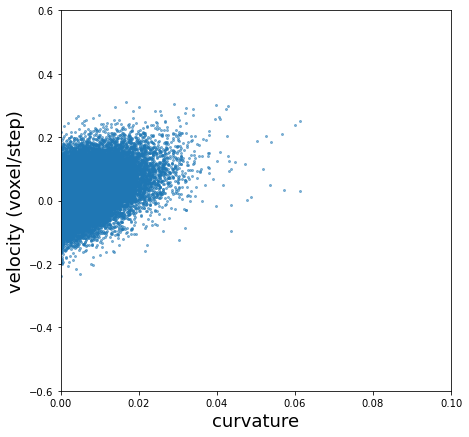

<Figure size 432x288 with 0 Axes>

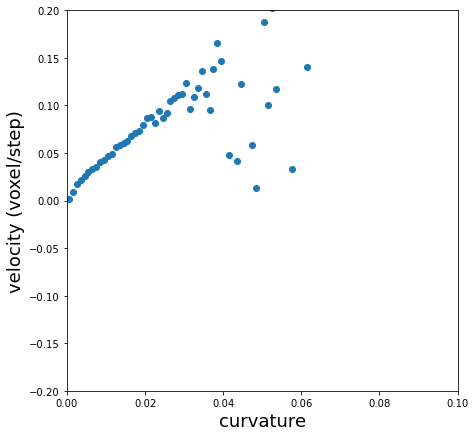

In [12]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
            
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(curvature_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.0,0.1])
    plt.ylim([-0.6,0.6])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>0.1: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.0,0.1])
    plt.ylim([-0.2,0.2])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

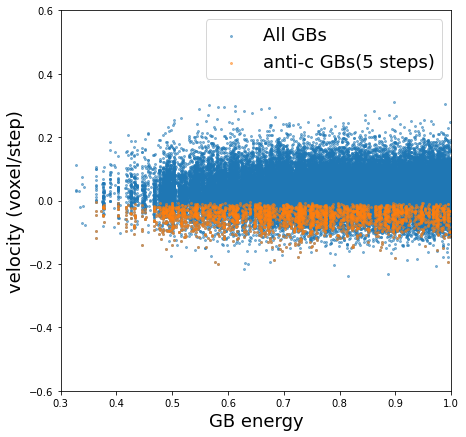

<Figure size 432x288 with 0 Axes>

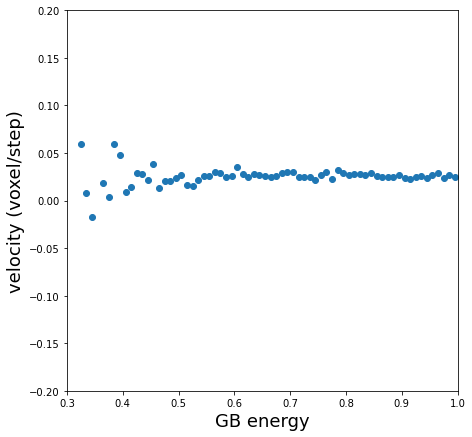

<Figure size 432x288 with 0 Axes>

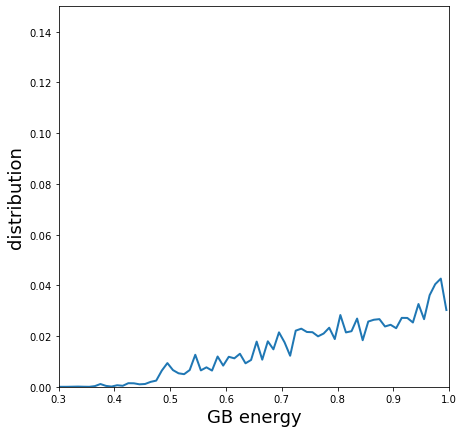

<Figure size 432x288 with 0 Axes>

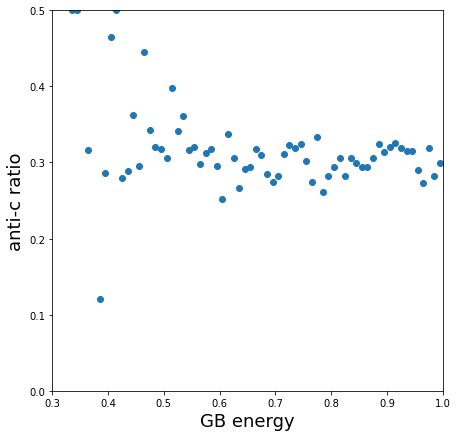

<Figure size 432x288 with 0 Axes>

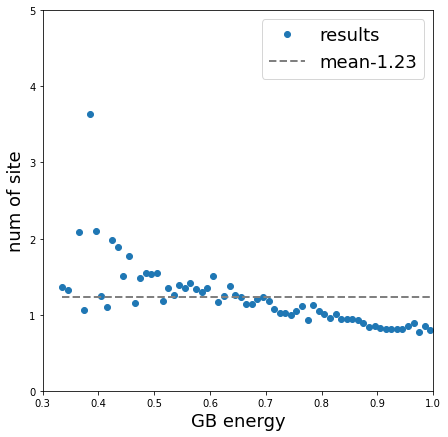

In [13]:

    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c ratio", fontsize=18)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [94]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>0.6: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

The longest anti-curvature behavior is 135601364 with steps 19
The anti-curvature step 8 has velocity - -0.018 and curvature - 0.038.
The anti-curvature step 10 has velocity - -0.04 and curvature - 0.018.
The anti-curvature step 12 has velocity - -0.03 and curvature - 0.016.
The anti-curvature step 14 has velocity - -0.016 and curvature - 0.001.
The anti-curvature step 15 has velocity - -0.047 and curvature - 0.009.
The anti-curvature step 19 has velocity - -0.112 and curvature - 0.018.
The anti-curvature step 21 has velocity - -0.055 and curvature - 0.009.
The anti-curvature step 24 has velocity - -0.008 and curvature - 0.007.
The anti-curvature step 25 has velocity - -0.055 and curvature - 0.007.
The anti-curvature step 29 has velocity - -0.018 and curvature - 0.013.
The anti-curvature step 31 has velocity - -0.025 and curvature - 0.024.
The anti-curvature step 33 has velocity - -0.067 and curvature - 0.036.
The anti-curvature step 34 has velocity - -0.009 and curvature - 0.013.
The 

Text(0.5, 1.0, 'GBid 135601364 step all')

<Figure size 432x288 with 0 Axes>

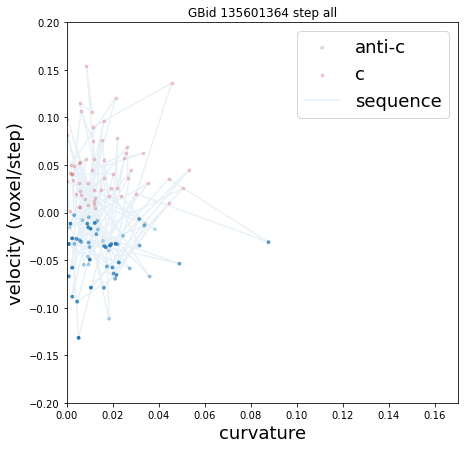

In [17]:
# Get more information for a focus GB

key_focus = 0
for key in GB_id_focus:
    if GB_id_focus[key] == 19: 
        print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
        key_focus = key
        # break

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        if current_curvature_value<0: 
            current_curvature_value = -current_curvature_value
            velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [212]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0

In [213]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# Find the exaxt grain id and time steps
GB_id = 145919744
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 24, 100
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [136]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [50]:
# # Plot more information for a focus GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [51]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [52]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')

## TJ study


In [53]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    for key in GB_id_unfocus_lowE_detail:
        for key_time in GB_id_unfocus_lowE_detail[key]:
            if key_time in GB_id_unfocus_lowE_detail_time:
                GB_id_unfocus_lowE_detail_time[key_time].append(key)
            else: 
                GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]
            
            
    # find the TJ around GB with anti-c behavior or low energy c behavior 
    site_energy_per_unit_focus_list = []
    site_energy_per_unit_unfocus_list = []
    for time_step in tqdm(range(step_num)):
        
        if time_step not in GB_id_focus_detail_time: current_focus_GB_id = []
        else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
        if time_step not in GB_id_unfocus_lowE_detail_time: current_unfocus_GB_id = []
        else: current_unfocus_GB_id = GB_id_unfocus_lowE_detail_time[time_step]
        if len(current_focus_GB_id) == 0 and len(current_unfocus_GB_id) == 0: continue
        # current_GB_id = []
        # current_GB_id.extend(current_focus_GB_id)
        # current_GB_id.extend(current_unfocus_GB_id)
        current_microstructure = npy_file_aniso[time_step]
        current_energy = npy_file_aniso_energy[time_step]
        
        

        
        size_x, size_y = npy_file_aniso[time_step].shape[0:2]
        k=0
        for i in range(size_x):
            for j in range(size_y):

                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                # find window and jump over GB and grain bulk
                neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                grain_id_num_in_window = np.unique(neighboring_sites_full_list)
                if len(grain_id_num_in_window) < 3: continue
                
                # 
                do_you_find = 0
                for current_key in current_focus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_focus_list.append(site_energy/num_nei)
                        do_you_find += 1
                        break
                if do_you_find > 0: continue
                for current_key in current_unfocus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_unfocus_list.append(site_energy/num_nei)
                        break
                        
                
    xLim = [0,2.0]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_focus = np.zeros(binNum)
    freqArray_unfocus = np.zeros(binNum)

    for i in range(len(site_energy_per_unit_focus_list)): freqArray_focus[int((site_energy_per_unit_focus_list[i] - xCor[0]) / binValue)] += 1
    for i in range(len(site_energy_per_unit_unfocus_list)): freqArray_unfocus[int((site_energy_per_unit_unfocus_list[i] - xCor[0]) / binValue)] += 1
        
            
            
            

100%|██████████| 121/121 [1:05:00<00:00, 32.23s/it]


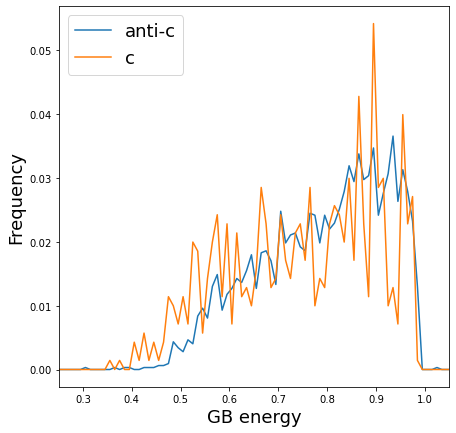

In [54]:
    freqArray_focus = freqArray_focus/np.sum(freqArray_focus)
    freqArray_unfocus = freqArray_unfocus/np.sum(freqArray_unfocus)

    plt.figure(figsize=(7,7))
    plt.plot(xCor, freqArray_focus, label='anti-c')
    plt.plot(xCor, freqArray_unfocus, label='c')
    plt.xlim([0.25,1.05])
    # plt.ylim([-0.15,0.15])
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
